In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import os  
import cv2 
import torch  
import imghdr  
import torchvision  
import numpy as np  
import pandas as pd 
import tensorflow as tf  
import matplotlib.pyplot as plt  
from sklearn.utils import shuffle 
from tensorflow.keras import layers  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  

In [2]:
#Importing our datasets
data_dir = '/kaggle/input/dataset1/filtered aug dataset'

In [3]:
#Building Data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 11257 files belonging to 2 classes.


In [4]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
len(data)

352

In [6]:
#resizing shape to none,224,224,3
import tensorflow as tf

# Assuming `dataset` is your original dataset with images of shape (256, 256, 3)
target_height, target_width = 224, 224

def resize_images(image, label):
    # Resize the image to the desired shape
    image = tf.image.resize(image, [target_height, target_width])
    return image, label

# Apply the resizing transformation to the dataset
data = data.map(resize_images)


In [7]:
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
len(data)

352

In [9]:
# Converting the dataset to an iterator
data_iterator = data.as_numpy_iterator()

# Acessing a batch from the Datapipeline
batch = data_iterator.next()
len(batch)

2

In [10]:
# Displaying the shape of the batch
batch[0].shape

(32, 224, 224, 3)

In [11]:
# Displaying the class labels
#Class 1 = Normal
#Class 0 = Down
batch[1]

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1], dtype=int32)

In [12]:
# Display the shape of the image batch
print(batch[0].shape)  # Should be (batch_size, height, width, channels)

# Display the labels
print(batch[1])  # Array of labels corresponding to the batch

(32, 224, 224, 3)
[0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1]


In [13]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1])
print(df_features)

    0
0   0
1   1
2   1
3   0
4   0
5   1
6   0
7   0
8   1
9   0
10  1
11  0
12  1
13  0
14  0
15  0
16  1
17  0
18  1
19  0
20  0
21  0
22  0
23  0
24  1
25  0
26  1
27  1
28  1
29  1
30  0
31  1


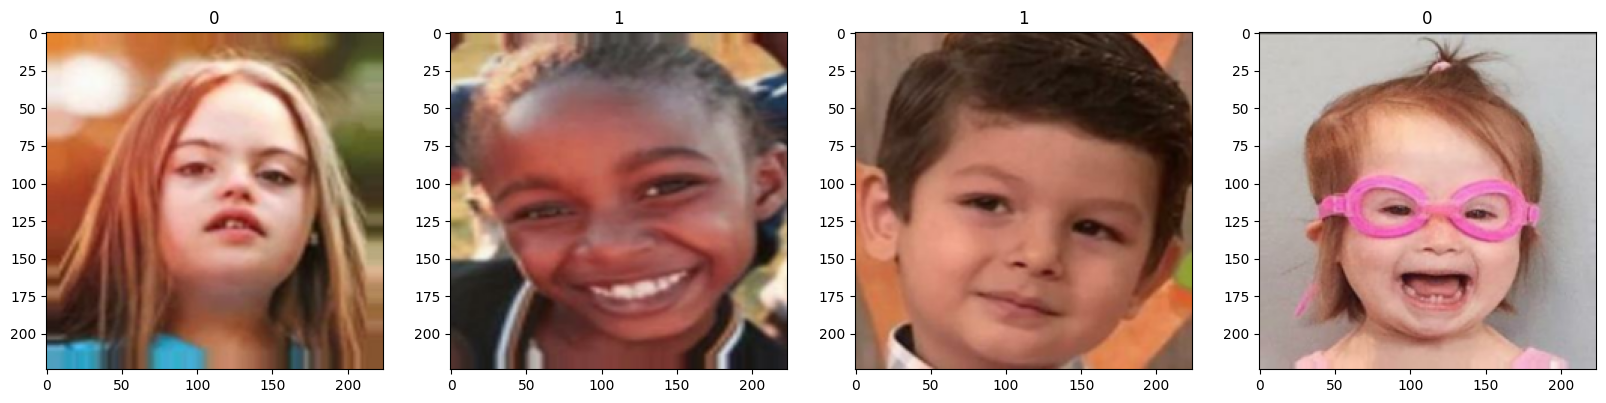

In [14]:
#Data visualization
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

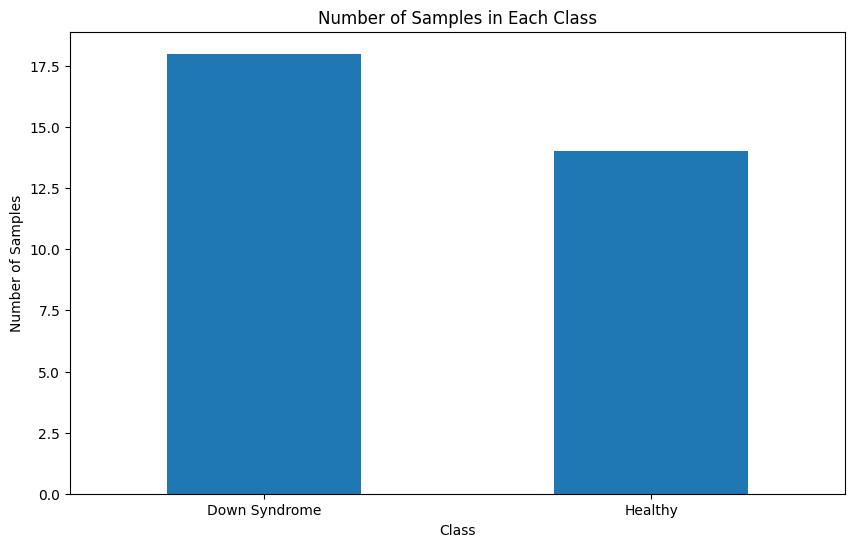

In [15]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1], columns=['Class'])

# Counting the number of samples in each class
class_counts = df_features['Class'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Number of Samples in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Down Syndrome', 'Healthy'], rotation=0)
plt.show()

In [16]:
class_counts

Class
0    18
1    14
Name: count, dtype: int64

In [17]:
#Data Preprocessing

#Data scaling
data = data.map(lambda x, y: (x / 255.0, y))  # Scale images to [0, 1]

# Verifying scaling
print(data.as_numpy_iterator().next()[0].min())  # Should print 0.0

0.0


In [18]:
#Checking lenght of dataset
len(data)

352

In [19]:
#Data splitting
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)

In [20]:
#checking our data size
train_size,val_size, test_size

(246, 52, 52)

In [21]:
#Assigning suitable variable names
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [22]:
#Creating Model¶
#I tried Different model architecture like VGG, mobilenet but DenseNet works best

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224, 224, 3)
                          )
    model = tf.keras.models.Sequential([
        densenet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model

Teacher = get_model()
Teacher.build(input_shape=(None, 224, 224, 3))  # Specify batch size as None for flexibility
Teacher.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,564,865 (28.86 MB)

 Trainable params: 7,480,193 (28.53 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

checkpoint = ModelCheckpoint(filepath='Teacher.keras',  # changed '.h5' to '.keras'
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='loss'  # changed 'val_loss' to 'loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='loss',  # changed 'val_loss' to 'loss'
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('Teacher_train.log')

callbacks = [checkpoint, reduce_lr, csv_logger]


In [25]:
# Fit the model with appropriate steps
hist = Teacher.fit(
    train,
    validation_data=val,
    callbacks=callbacks,
    epochs=10
)

Epoch 1/10


I0000 00:00:1731738176.782460     100 service.cc:145] XLA service 0x7ed080007d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731738176.782519     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731738267.381932     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8279 - loss: 0.4389
Epoch 1: loss improved from inf to 0.28146, saving model to Teacher.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 214s 264ms/step - accuracy: 0.8281 - loss: 0.4382 - val_accuracy: 0.8522 - val_loss: 0.5564 - learning_rate: 0.0010
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9628 - loss: 0.1117
Epoch 2: loss improved from 0.28146 to 0.09517, saving model to Teacher.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 58s 234ms/step - accuracy: 0.9628 - loss: 0.1117 - val_accuracy: 0.9561 - val_loss: 0.1092 - learning_rate: 0.0010
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9736 - loss: 0.0759
Epoch 3: loss improved from 0.09517 to 0.07660, saving model to Teacher.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 57s 231ms/step - accuracy: 0.9736 - loss: 0.0759 - val_accuracy: 0.9243 - val_loss: 0.1992 - learning_rate: 0.0010
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9692 - loss: 0.0

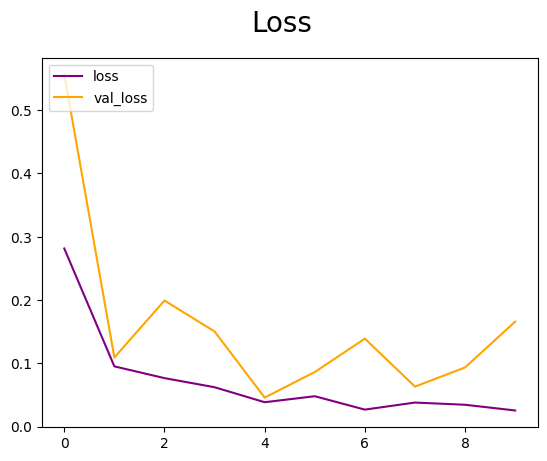

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='purple', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

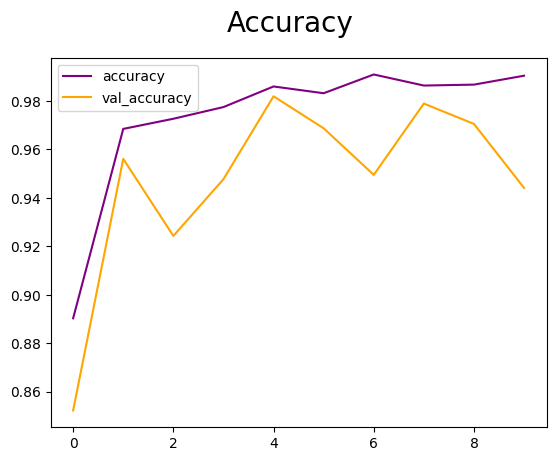

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='purple', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

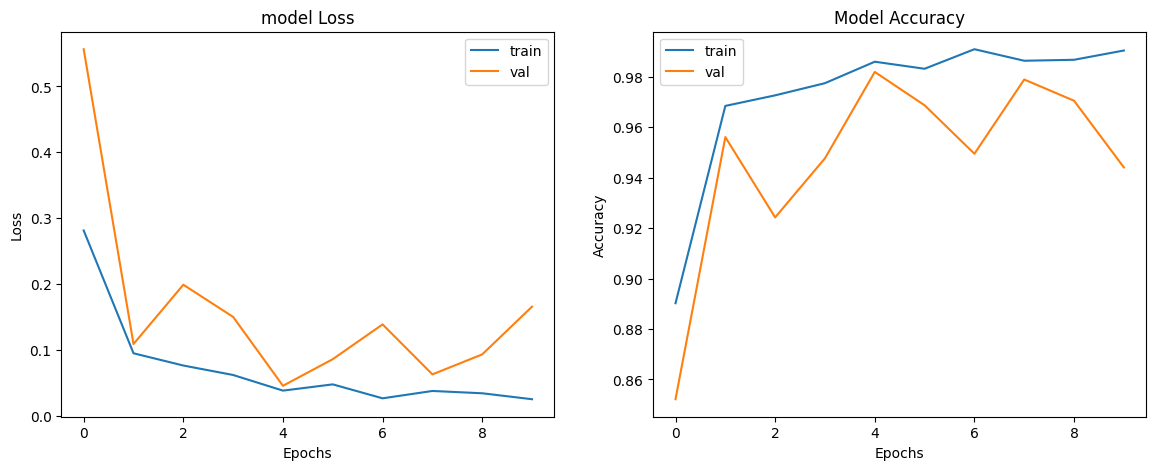

In [28]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [29]:
_, accu = Teacher.evaluate(test)
print('Final Test Accuracy = {:.3f}%'.format(accu * 100))

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9424 - loss: 0.1658
Final Test Accuracy = 93.570%


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━

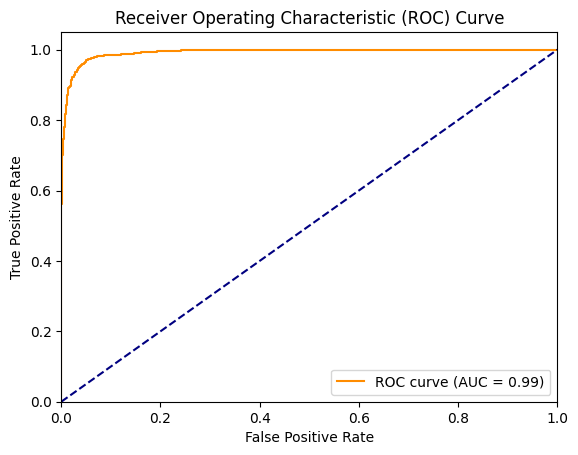

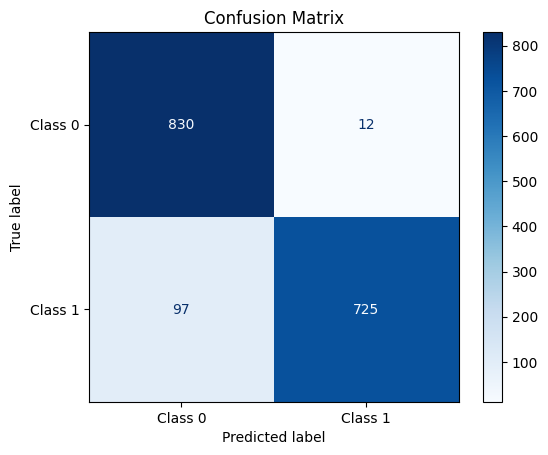

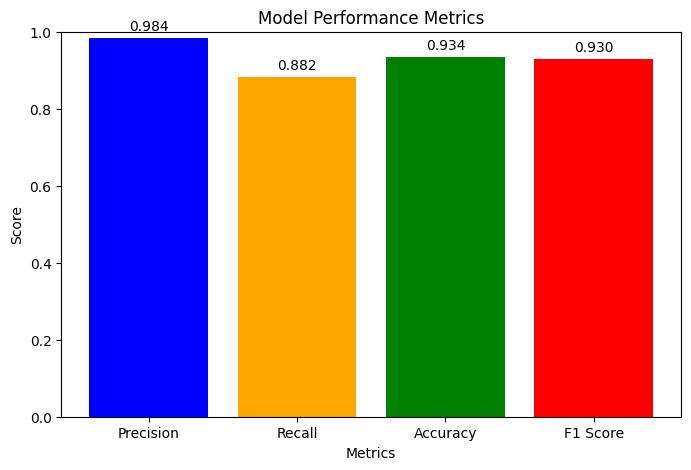

In [30]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Predict labels and probabilities for the test set
true_labels = []
pred_labels = []
pred_probs = []  # Store probabilities for ROC curve

for batch in test:  # Assuming `test` is your test dataset
    images, labels = batch
    predictions = Teacher.predict(images)  # Replace with your model name if different
    true_labels.extend(labels.numpy())
    pred_labels.extend((predictions > 0.5).astype("int32").flatten())
    pred_probs.extend(predictions.flatten())  # Store probabilities for ROC

# Step 2: Calculate precision, recall, accuracy, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Step 3: Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"],
    "Score": [precision, recall, accuracy, f1]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Step 4: Compute and plot the ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Step 5: Compute the confusion matrix and plot it
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 6: Plot the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
for i in range(len(metrics_df)):
    plt.text(i, metrics_df['Score'][i] + 0.02, f"{metrics_df['Score'][i]:.3f}", ha='center')

plt.show()


In [31]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


# **Student Model**

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, Input


student = Sequential()
student.add(Input(shape=(224, 224, 3))) 


student.add(Conv2D(32, (3, 3), activation='relu'))  
student.add(BatchNormalization())  
student.add(MaxPooling2D(pool_size=(2, 2)))  
student.add(Dropout(0.3))  

student.add(Conv2D(64, (3, 3), activation='relu'))  
student.add(BatchNormalization())  
student.add(MaxPooling2D(pool_size=(2, 2)))  
student.add(Dropout(0.4))  

student.add(Conv2D(128, (3, 3), activation='relu'))  
student.add(BatchNormalization())  
student.add(MaxPooling2D(pool_size=(2, 2)))  
student.add(Dropout(0.4))  

student.add(Conv2D(256, (3, 3), activation='relu'))  
student.add(BatchNormalization())  
student.add(MaxPooling2D(pool_size=(2, 2)))  
student.add(Dropout(0.5))  


student.add(GlobalAveragePooling2D())  


student.add(Dense(512, activation='relu'))  
student.add(Dropout(0.5))  


student.add(Dense(1))  


In [34]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=Teacher)


# **Compile Student With alpha=0.2, Temp=10 distillation**

In [41]:
distiller.compile(
    optimizer=keras.optimizers.Adam(),  # Lower learning rate
    metrics=[keras.metrics.BinaryAccuracy()],
    student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),  # Ensure student output is logits
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=10,
)
#learning_rate=1e-4

In [42]:
logdir = 'Distilled_Student_Train' 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# **Train Student With alpha=0.2, Temp=10 distillation**

In [46]:
# Distill teacher to student
history3 = distiller.fit(train, 
                         epochs=10,
                         callbacks=[tensorboard_callback],
                         validation_data=val, 
                         verbose=1)            

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - binary_accuracy: 0.9740 - distillation_loss: 0.0000e+00 - loss: 1.4822 - student_loss: 0.0662 - val_binary_accuracy: 0.8582 - val_loss: 9.6044 - val_student_loss: 0.1479
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - binary_accuracy: 0.9747 - distillation_loss: 0.0000e+00 - loss: 1.4736 - student_loss: 0.0594 - val_binary_accuracy: 0.5325 - val_loss: -20.3937 - val_student_loss: 10.8962
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - binary_accuracy: 0.9674 - distillation_loss: 0.0000e+00 - loss: 1.4663 - student_loss: 0.0707 - val_binary_accuracy: 0.9339 - val_loss: 5.4985 - val_student_loss: 0.2154
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - binary_accuracy: 0.9787 - distillation_loss: 0.0000e+00 - loss: 1.6318 - student_loss: 0.0595 - val_binary_accuracy: 0.9754 - val_loss: 2.9871 - val_student_loss: 0.0059
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - binary_accuracy: 0.9794 - distil

# **Evaluate student**

In [47]:
# Evaluate student on test dataset
distiller.evaluate(test)


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - binary_accuracy: 0.9614 - loss: 1.1620 - student_loss: 0.0967


[0.8193484544754028,
 0.8193484544754028,
 0.963942289352417,
 0.013119708746671677]

# **Confusion Matrix , Classification Matrix, ROC Curve**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

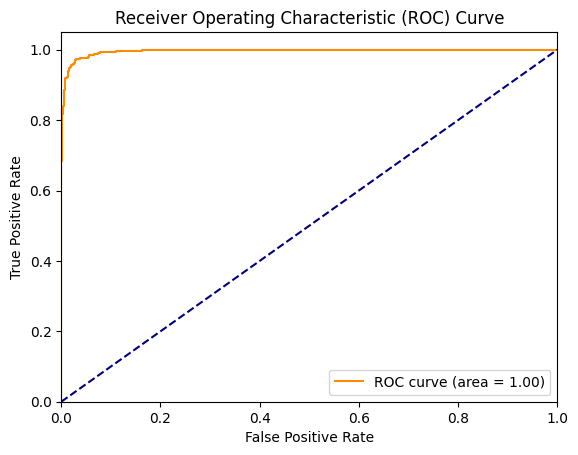

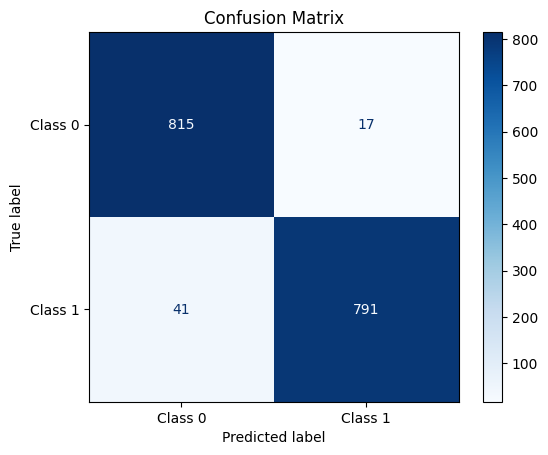

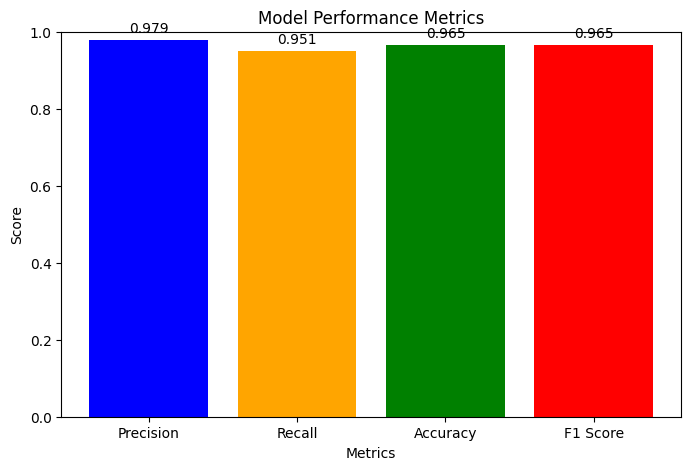

In [48]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Predict labels and probabilities for the test set
true_labels = []
pred_labels = []
pred_probs = []  # To store probabilities for ROC

for batch in test:  # Assuming `test` is your test dataset
    images, labels = batch
    predictions = distiller.student.predict(images)  # Change to `teacher` or `student` as needed
    true_labels.extend(labels.numpy())
    pred_labels.extend((predictions > 0.5).astype("int32").flatten())
    pred_probs.extend(predictions.flatten())  # Store probabilities for ROC

# Step 2: Calculate precision, recall, accuracy, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Step 3: Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"],
    "Score": [precision, recall, accuracy, f1]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Step 4: Compute and plot the ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Step 5: Compute the confusion matrix and plot it
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 6: Plot the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
for i in range(len(metrics_df)):
    plt.text(i, metrics_df['Score'][i] + 0.02, f"{metrics_df['Score'][i]:.3f}", ha='center')

plt.show()
